In [21]:
import os
os.chdir('/home/aisinai/work/repos/deepmatch-simulation')

In [1]:
# Dataset imports
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression, make_classification

# Visualization imports
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

### Toying Around with Classification Data Generation

In [106]:
TOY_CL_KWARGS = {
    'n_samples' : 100000,
    'n_features' : 500, 
    'n_informative' : 50, # 10% of features are important for assigning treatment
    'n_redundant' : 250, # rank of no more than 250
    'n_repeated' : 0, # no repeated features, so remaining ones are 
    'n_classes' : 2,
    'n_clusters_per_class' : 2, # increasing this may increase the difficulty of identifying clusters of treatment in data space.
    'weights' : [0.95, 0.05], # probability of no_treatment to treatment
    'flip_y' : 0.1,
    'class_sep' : 1,
    'random_state' : 0,
}

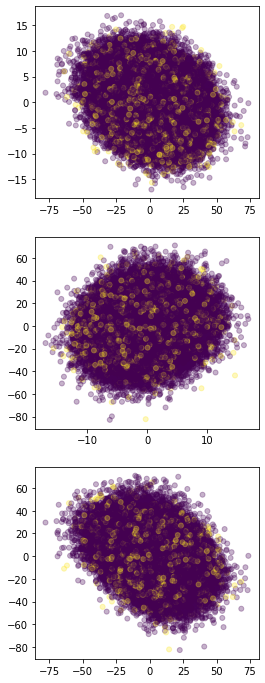

In [107]:
X, y = make_classification(**TOY_CL_KWARGS)
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(4, 12))

ax[0].scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=25, alpha=0.3)
ax[1].scatter(X[:, 1], X[:, 2], marker='o', c=y,
            s=25, alpha=0.3)
ax[2].scatter(X[:, 0], X[:, 2], marker='o', c=y,
            s=25, alpha=0.3)

In [108]:
np.save('data/simulation_data_X_095.npy', X)
np.save('data/simulation_data_Y_095.npy', y)

### See Model Performance

In [112]:
import torch
import torch.nn as nn

from model.autoencoder import AutoEncoder
from data.data_loader import SimulationDataset

In [110]:
state_inds = {
    'case' : np.where(y == 1)[0],
    'control' : np.where(y == 0)[0]
}

state_inds['case'].shape, state_inds['control'].shape

((9506,), (90494,))

In [117]:
db = SimulationDataset('data/simulation_data_X_095.npy', 'control', state_inds=state_inds)

In [76]:
DEFAULT_BUILD = {
    'data' : {
        'input_features' : 500
    },
    
    'embedding' : {
        'dims' : 50
    },
    
    'encoding' : {
        'total_layers' : 1,
        'scale' : 4,
        'activation' : 'leaky_relu',
    },

    'latent' : {'dimensions' : 64},

    'decoding' : {
        'scale' : 4,
        'activation' : 'leaky_relu',
        'total_layers' : 1,
        'output_dims' : None
    }
}

ae = AutoEncoder(DEFAULT_BUILD)
ae.load_state('/home/aisinai/work/repos/deepmatch-simulation/experiments/train_sim_01/1595273441.pth')

In [39]:
X

array([[  0.34137317,   3.35635924,   4.61651962, ..., -17.15950107,
         -1.47960205,  38.75422853],
       [  1.24634697,   1.04890458,   8.37357739, ...,  -7.20074245,
          1.3846946 , -14.41470657],
       [ -0.11307552,  -8.62954435,  -6.17369918, ...,  -2.78948074,
          1.29088876, -19.99913463],
       ...,
       [ -0.32592527,   3.66538556,  22.55791411, ...,   8.88371508,
          1.24684288,   0.51328708],
       [  0.3563832 ,   0.24766246,   0.60415486, ..., -29.00347188,
          0.58130962,  17.65914036],
       [  1.01670996,   2.35667413,  10.73067629, ...,  -4.66817428,
         -0.89764259,  -2.04919641]])

In [85]:
Xt = torch.Tensor(X[80000:, :])

In [86]:
Xhat = ae.predict(Xt)

In [88]:
(np.abs(Xt - Xhat) / np.abs(Xt))

tensor([[0.9943, 0.0356, 0.0396,  ..., 0.0058, 0.9845, 0.0037],
        [1.0198, 0.0585, 0.0485,  ..., 0.0247, 0.9904, 0.0045],
        [1.0980, 0.0095, 0.0017,  ..., 0.0356, 0.9851, 0.0105],
        ...,
        [1.0205, 0.0122, 0.0507,  ..., 0.0627, 0.9779, 0.1313],
        [0.9792, 0.0323, 0.4727,  ..., 0.0057, 0.9942, 0.0038],
        [1.0464, 0.0192, 0.0355,  ..., 0.0127, 0.9844, 0.0496]])

In [89]:
(np.abs(Xt - Xhat) / np.abs(Xt)).mean()

tensor(0.8168)

In [63]:
Xembed = ae.latent_representation(Xt)